## Day 3: Cells in Silicon

Welcome to Day 3! Today, we start with our discussion with the Hodgkin Huxley Neurons and how we can simulate them in python using Tensorflow and Numerical Integration.

### What is the Hodgkin Huxley Neuron Model? 
(Modified from Neuronal Dynamics, EPFL)

Hodgkin and Huxley performed many experiments on the giant axon of the squid and found three different types of ion currents - sodium, potassium, and a leak current. They found that specific voltage-dependent ion channels, for sodium and for potassium, control the flow of those ions through the cell membrane from different electrophysiology studies involving phamacological blocking of ion channels. The leak current essentially takes care of other channel types which are not described explicitly. 

<img src="cd.png" alt="cd.png" width="600"/>

The Hodgkin-Huxley model of neurons can easily be understood with the help of a circuit diagram. The semipermeable cell membrane separates the interior of the cell from the extracellular liquid and acts as a capacitor. If an input current I(t) is injected into the cell, it may add further charge on the capacitor, or leak through the channels in the cell membrane. Because of active ion transport through the cell membrane, the ion concentration inside the cell is different from that in the extracellular liquid. The Nernst potential generated by the difference in ion concentration is represented by a battery.

Let us now translate the above considerations into mathematical equations. The conservation of electric charge on a piece of membrane implies that the applied current $I(t)$ may be split in a capacitive current $I_C$ which charges the capacitor $C_m = 1 \mu F/cm^2$ and further components $I_k$ which pass through the ion channels. Thus $I(t) = I_C(t) + \sum_kI_k(t)$ where the sum runs over all ion channels. 

In the standard Hodgkin-Huxley model, there are only three types of channel: a Sodium channel, a Potassium channel and an unspecific leakage channel. From the definition of a capacitance $C_m=\frac{q}{u}$, $I_C=C_m\frac{du}{dt}$ where $q$ is a charge and $u$ the voltage across the capacitor. Thus the model becomes:

$$C_m\frac{du}{dt}=−I_{Na}(t)−I_{K}(t)−I_{L}(𝑡)+I(t)$$

In biological terms, $u$ is the voltage across the membrane. Hogkin and Huxley found the Na and K ion currents to be dependent on the voltage and of the form given below:

$$I_{Na} = g_{Na}m^3h(u−E_{Na})$$

$$I_K = g_Kn^4(u−E_K)$$

$$I_L = g_L(u−E_L)$$

where $E_{Na}=50\ mV$, $E_K = -95\ mV$ and $E_L=-55\ mV$ are the reversal potentials; $g_{Na} = 100\ \mu S/cm^2$, $g_K = 10\ \mu S/cm^2$ and $g_L = 0.15\ \mu S/cm^2$ are the channel conductances; and m,h, and n are gating variables that follow the dynamics given by:

$$\frac{dm}{dt} = - \frac{1}{\tau_m}(m-m_0)$$

$$\frac{dh}{dt} = - \frac{1}{\tau_h}(h-h_0)$$

$$\frac{dn}{dt} = - \frac{1}{\tau_n}(n-n_0)$$

where $\tau_m$, $\tau_h$ and $\tau_n$ are voltage dependent time constants and $m_0$, $h_0$ and $n_0$ are voltage dependent asymptotic gating values. These functions are empirically determined for different types of neurons.

<img src="dyn.png" alt="dyn.png" width="800"/>


#### Recalling the Generalized TensorFlow Integrator
On day 2, we had created a RK4 based numerical integrator. We recall the implementation of the Integrator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline


def tf_check_type(t, y0): # Ensure Input is Correct
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error in Datatype')

class _Tf_Integrator():
    
    def integrate(self, func, y0, t): 
        time_delta_grid = t[1:] - t[:-1]
        
        def scan_func(y, t_dt): 
            t, dt = t_dt
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            return y + dy
        
        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
        return tf.concat([[y0], y], axis=0)
    
    
    def _step_func(self, func, t, dt, y):
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)
    

def odeint(func, y0, t):
    t = tf.convert_to_tensor(t, preferred_dtype=tf.float64, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t)
    return _Tf_Integrator().integrate(func,y0,t)

#### Implementing the Dynamical Function for an Hodkin Huxley Neuron

Recall, a simple Hodgkin Huxley Neuron has a 4 main dynamical variables:

$V = Membrane\ Potential$  
$m = Sodium\ Activation\ Gating\ Variable$  
$h = Sodium\ Inactivation\ Gating\ Variable$  
$n = Potassium\ Channel\ Gating\ Variable$

And the dynamics are given by:

$$C_m\frac{dV}{dt} = I_{injected} - I_{Na} - I_K - I_L$$

$$\frac{dm}{dt} = - \frac{1}{\tau_m}(m-m_0)$$

$$\frac{dh}{dt} = - \frac{1}{\tau_h}(h-h_0)$$

$$\frac{dn}{dt} = - \frac{1}{\tau_n}(n-n_0)$$

where the values of $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$ are given from the equations mentioned earlier.

##### Step 1: Defining Parameters of the Neuron 

In [2]:
C_m = 1      # Membrane Capacitance

g_K = 10
E_K = -95

g_Na = 100
E_Na = 50 

g_L = 0.15
E_L = -55

##### Step 2: Defining functions that calculate $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$ 

Note: Always use Tensorflow functions for all mathematical operations.

For our Hodgkin Huxley Model, we will determine the values of $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$  by the following equations:

<img src="eqns1.png" alt="eqns1.png" width="600"/>

In [3]:
def K_prop(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    
    return n_0, t_n


def Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    
    return m_0, t_m, h_0, t_h

##### Step 3: Defining function that calculate Neuronal currents

<img src="eqns2.png" alt="eqns2.png" width="600"/>

In [4]:
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

##### Step 4: Define the function dX/dt where X is the State Vector

In [5]:
def dXdt(X, t):
    V = X[0:1]
    m = X[1:2]
    h = X[2:3]
    n = X[3:4]
    
    dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m 
    # Here the current injection I_injected = 5 uA
    
    m0,tm,h0,th = Na_prop(V)
    n0,tn = K_prop(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)

    out = tf.concat([dVdt,dmdt,dhdt,dndt],0)
    return out

##### Step 5: Define Initial Condition and Integrate

In [6]:
y0 = tf.constant([-71,0,0,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,200,epsilon)

state = odeint(dXdt,y0,t)

with tf.Session() as sess:
    state = sess.run(state)

##### Step 6: Plot Output

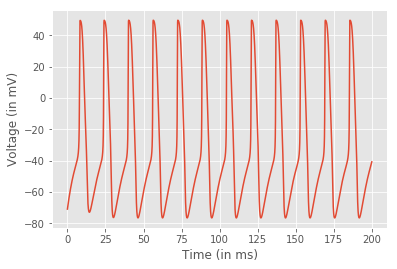

In [8]:
plt.style.use('ggplot')

plt.plot(t,state.T[0,:])

plt.xlabel("Time (in ms)")
plt.ylabel("Voltage (in mV)")

fig = plt.gcf()
fig.savefig("fig4.eps",format='eps')

plt.show()

#### Simulating Multiple Independent HH Neurons at the Same Time

Although, simulating a Single Hodgkin-Huxley Neuron is possible in TensorFlow, the real ability of tensorflow can be seen only when a large number of simultaneous diffential equations are to be solved at the the same time. Let's try to simulate 20 independent HH neurons with different input currents and characterise the firing rates. 

##### Methods of Parallelization
TensorFlow has the intrinsic ability to speed up any and all Tensor computations using available multi-cores, and GPU/TPU setups. There are two major parts of the code where TensorFlow can help us really speed up the computation:
1. **RK4 Steps:** Since the TensorFlow implementation of the Integrator utilizes Tensor calculations, TensorFlow will automatically speed it up.
2. **Functional Evaluations:** Looking at Dynamical Equations that describe the neuronal dynamics, its easy to notice that all simple HH Neurons share the same or atleast similar dynamical equations but will vary only in the values of parameters. We can exploit this to speed up the computations.


Say $\vec{X}=[V,m,n,h]$ is the state vector of a single neuron and its dynamics are defined using parameters $C_m,g_K,...E_L$ equations of the form: $$\frac{d\vec{X}}{dt} = [f_1(\vec{X},C_m,g_K,...E_L),f_2(\vec{X},C_m,g_K,...E_L)...f_m(\vec{X},C_m,g_K,...E_L)]$$ We have to somehow convert these to a form in which all evaluations are done as vector calculations and NOT scalar calculations.

So, what we need for a system of n neurons is to have a method to evaluate the updation of $\mathbf{X}=[\vec{X_1},\vec{X_2}...\vec{X_n}]$ where $\vec{X_i}=[V_1,m_1,n_1,h_1]$ is the state vector of the $i$th neuron. Now there is a simple trick that allows us to maximize the parallel processing. Each neuron represented by $\vec{X_i}$ has a distinct set of parameters and differential equations.

Now, despite the parameters being different, the functional forms of the updation is similar for the same state variable for different neurons. Thus, the trick is to reorganize $\mathbf{X}$ as $\mathbf{X'}=[(V_1,V_2,...V_n),(m_1,m_2,...m_n),(h_1,h_2,...h_n),(n_1,n_2,...n_n)]=[\vec{V},\vec{m},\vec{h},\vec{n}]$. And the parameters as $\vec{C_m},\vec{g_K}$ and so on.

Now that we know the trick, what is the benefit? Earlier, each state variable (say $V_i$) had a DE of the form: $$\frac{dV_i}{dt}=f(V_i,m_i,h_i,n_i,C_{m_i},g_{K_i}...)$$ This is now easily parallelizable using a vector computation of a form: $$\frac{d\vec{V}}{dt}=f(\vec{V},\vec{m},\vec{h},\vec{n},\vec{C_m},\vec{g_K}...)$$

Thus we can do the calculations as:
$$\frac{d\mathbf{X'}}{dt}= \Big[\frac{d\vec{V}}{dt},\frac{d\vec{m}}{dt},\frac{d\vec{h}}{dt},\frac{d\vec{n}}{dt}\Big]$$

In [9]:
n_n = 20 # number of simultaneous neurons to simulate

# parameters will now become n_n-vectors

C_m = [1.0]*n_n
g_K = [10.0]*n_n
E_K = [-95.0]*n_n

g_Na = [100]*n_n
E_Na = [50]*n_n 

g_L = [0.15]*n_n
E_L = [-55.0]*n_n


def K_prop(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_0 = alpha_n/(alpha_n+beta_n)
    
    return n_0, t_n


def Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_0 = alpha_m/(alpha_m+beta_m)
    h_0 = alpha_h/(alpha_h+beta_h)
    
    return m_0, t_m, h_0, t_h

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

def dXdt(X, t):
    V = X[:1*n_n]       # First n_n values are Membrane Voltage
    m = X[1*n_n:2*n_n]  # Next n_n values are Sodium Activation Gating Variables
    h = X[2*n_n:3*n_n]  # Next n_n values are Sodium Inactivation Gating Variables
    n = X[3*n_n:]       # Last n_n values are Potassium Gating Variables
    
    dVdt = (np.linspace(0,10,n_n) - I_Na(V, m, h) - I_K(V, n) -I_L(V)) / C_m 
    # Input current is linearly varied between 0 and 10
    
    m0,tm,h0,th = Na_prop(V)
    n0,tn = K_prop(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)

    out = tf.concat([dVdt,dmdt,dhdt,dndt],0)
    return out


y0 = tf.constant([-71]*n_n+[0,0,0]*n_n, dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,200,epsilon)

state = odeint(dXdt,y0,t)

with tf.Session() as sess:
    state = sess.run(state)

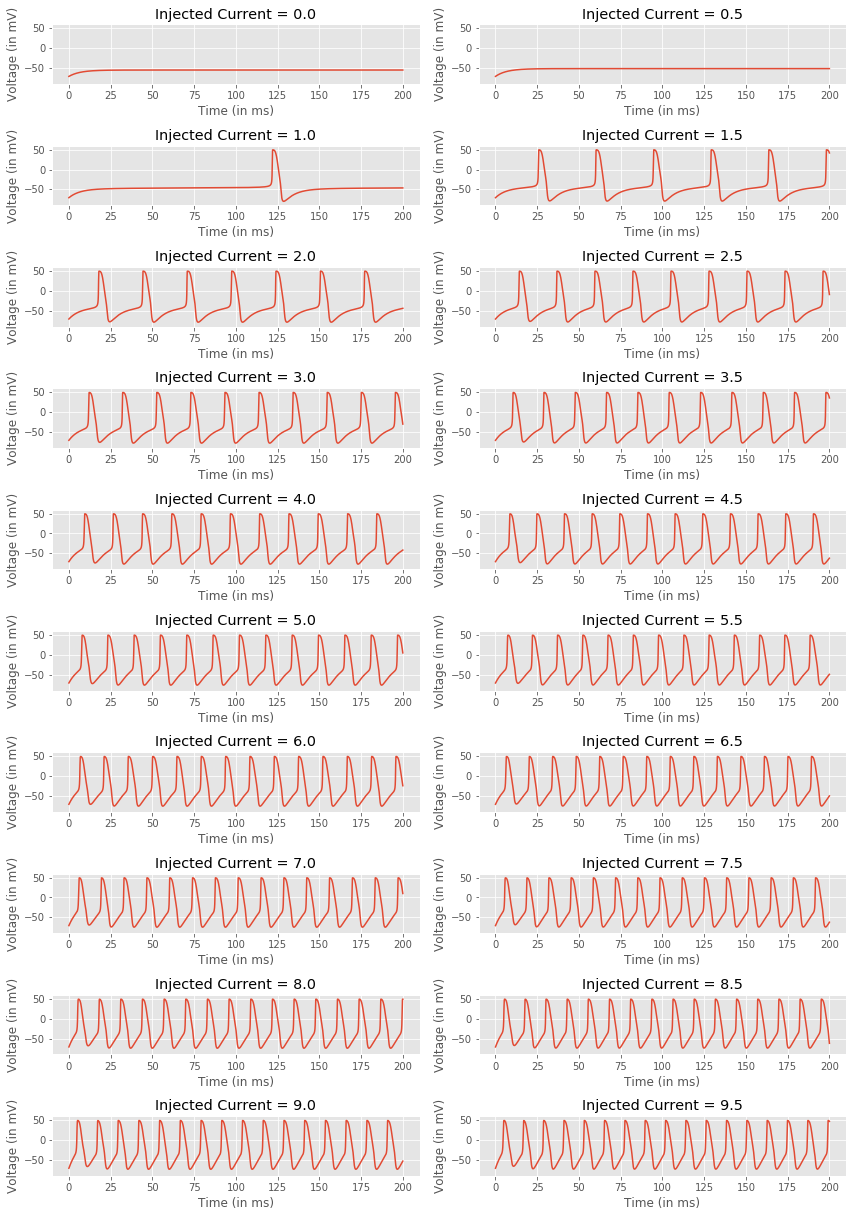

In [13]:
plt.figure(figsize=(12,17))
for i in range(20):
    plt.subplot(10,2,i+1)
    plt.plot(t,state[:,i])
    plt.title("Injected Current = {:0.1f}".format(i/2))
    plt.ylim([-90,60])
    plt.xlabel("Time (in ms)")
    plt.ylabel("Voltage (in mV)")

plt.tight_layout()
fig = plt.gcf()
fig.savefig("fig5.eps",format='eps')
plt.show()

#### Quantifying the Firing Rates against Input Current

One way to quantify the firing rate is to perform a fourier analysis and find peak frequency, but an easier way to find the rate is to see how many times it crosses a threshold say 0 mV in a given time, here it is for 200ms = 0.2s, and find the rate.

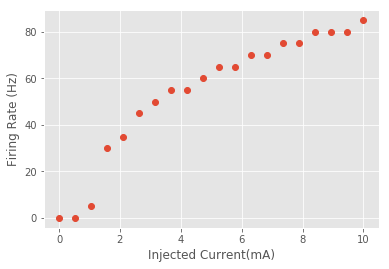

In [14]:
plt.plot(np.linspace(0,10,20),np.bitwise_and(state[:-1,:20]<0,state[1:,:20]>0).sum(axis=0)/0.2,"o")
plt.xlabel("Injected Current(mA)")
plt.ylabel("Firing Rate (Hz)")
fig = plt.gcf()
fig.savefig("fig6.eps",format='eps')
plt.show()